# UMICH SI650 - Sentiment Classification
- https://www.kaggle.com/c/si650winter11/data

In [1]:
# # nltk: Natural Language Toolkit
# !pip install nltk

In [2]:
from keras.layers.core import Activation, Dense, Dropout, SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
import collections
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
%matplotlib inline

Using TensorFlow backend.


### Hyperparameters

In [3]:
DATA_DIR = "./data"

MAX_FEATURES = 2000
MAX_SENTENCE_LENGTH = 40

EMBEDDING_SIZE = 128
HIDDEN_LAYER_SIZE = 64
BATCH_SIZE = 32
NUM_EPOCHS = 10

In [4]:
# nltk.download('punkt')

### Read the data
- 여기서는 학습데이터의 문장 길이, 단어 수를 체크

In [5]:
# Read training data and generate vocabulary
maxlen = 0
word_freqs = collections.Counter()
num_recs = 0
ftrain = open(os.path.join(DATA_DIR, "umich_sentiment.txt"), 
              'r', 
              encoding='utf-8')
for line in ftrain:
    label, sentence = line.strip().split("\t")
    words = nltk.word_tokenize(sentence.lower())
#     words = sentence.lower().split(' ')
    if len(words) > maxlen:
        maxlen = len(words)
    for word in words:
        word_freqs[word] += 1
    num_recs += 1
ftrain.close()

In [6]:
# Get some information about our corpus
print(maxlen)            # 42
print(len(word_freqs))   # 2313

42
2328


### Preprocessing the data
- 기존에 등장하지 않는 어휘가 등장했을 때, 그리고 zero-padding이 필요한 것을 고려하여 **UNK**와 **PAD**라는 표현을 vocabulary에 포함하고 인덱스를 부여

In [7]:
vocab_size = min(MAX_FEATURES, len(word_freqs)) + 2
word2index = {x[0]: i+2 for i, x in 
                enumerate(word_freqs.most_common(MAX_FEATURES))}
word2index["PAD"] = 0
word2index["UNK"] = 1
index2word = {v:k for k, v in word2index.items()}

In [8]:
print(word2index.keys())

dict_keys(['i', ',', '.', 'the', 'and', '!', 'harry', 'vinci', 'da', 'brokeback', 'code', 'mountain', 'potter', '...', 'love', 'is', 'a', 'was', 'mission', 'impossible', 'awesome', 'like', 'it', 'to', 'movie', 'that', "'s", 'because', 'sucks', 'hate', 'sucked', 'so', 'as', 'my', '``', 'much', 'of', 'really', 'movies', 'stupid', 'you', 'down', 'but', 'we', 'be', 'with', 'just', 'one', 'know', 'potter..', 'suck', 'out', '3', 'who', '/', 'or', 'am', 'loved', 'want', 'into', 'which', 'right', 'for', 'an', "n't", 'this', 'me', ':', 'are', 'think', 'not', 'how', 'if', 'depressing', 'people', 'his', 'would', 'up', 'reading', 'why', 'series', 'there', 'in', 'only', 'fucking', 'terrible', 'she', 'oh', 'story', 'being', '..', 'left', 'ok', 'guy', 'here', 'start', 'felicia', '(', 'have', 'book', 'about', 'beautiful', 'good', 'also', 'too', 'on', 'went', 'do', 'read', 'at', 'then', 'can', 'saw', 'first', 'by', 'tom', 'more', 'thought', 'most', '2', 'liked', 'way', 'from', 'absolutely', 'still', 'h

In [9]:
# 실제 학습데이터를 위에서 부여한 인덱스의 sequence로 변경
X = np.empty((num_recs, ), dtype=list)
y = np.zeros((num_recs, ))
i = 0
ftrain = open(os.path.join(DATA_DIR, "umich_sentiment.txt"), 'r', encoding='utf-8')
for line in ftrain:
    label, sentence = line.strip().split("\t")
    words = nltk.word_tokenize(sentence.lower())
    seqs = []
    for word in words:
        if word in word2index:
#         if word2index.has_key(word):
            seqs.append(word2index[word])
        else:
            seqs.append(word2index["UNK"])
    X[i] = seqs
    y[i] = int(label)
    i += 1
ftrain.close()

In [10]:
print(X[0])
print(y[0])

[5, 10, 9, 12, 101, 17, 48, 22, 4]
1.0


In [11]:
# Pad the sequences (left padded with zeros)
X = sequence.pad_sequences(X, maxlen=MAX_SENTENCE_LENGTH)

print(X[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   5  10   9  12 101
  17  48  22   4]


In [12]:
# Split input into training and test
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, 
                                                random_state=42)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(5668, 40) (1418, 40) (5668,) (1418,)


### Build the model

In [13]:
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_SIZE, 
                    input_length=MAX_SENTENCE_LENGTH))
model.add(LSTM(HIDDEN_LAYER_SIZE, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1))
model.add(Activation("sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", 
              metrics=["accuracy"])

In [14]:
history = model.fit(Xtrain, ytrain, batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_data=(Xtest, ytest))

Train on 5668 samples, validate on 1418 samples
Epoch 1/10
5668/5668 [==============================] - 9s 2ms/step - loss: 0.2315 - acc: 0.8950 - val_loss: 0.0731 - val_acc: 0.9725
Epoch 2/10
5668/5668 [==============================] - 9s 2ms/step - loss: 0.0253 - acc: 0.9935 - val_loss: 0.0392 - val_acc: 0.9866
Epoch 3/10
5668/5668 [==============================] - 9s 2ms/step - loss: 0.0077 - acc: 0.9981 - val_loss: 0.0454 - val_acc: 0.9838
Epoch 4/10
5668/5668 [==============================] - 9s 2ms/step - loss: 0.0060 - acc: 0.9991 - val_loss: 0.0554 - val_acc: 0.9887
Epoch 5/10
5668/5668 [==============================] - 9s 2ms/step - loss: 0.0018 - acc: 0.9995 - val_loss: 0.0504 - val_acc: 0.9873
Epoch 6/10
5668/5668 [==============================] - 10s 2ms/step - loss: 0.0013 - acc: 0.9996 - val_loss: 0.0495 - val_acc: 0.9880
Epoch 7/10
5668/5668 [==============================] - 10s 2ms/step - loss: 0.0022 - acc: 0.9996 - val_loss: 0.0489 - val_acc: 0.9894
Epoch 8/10
5

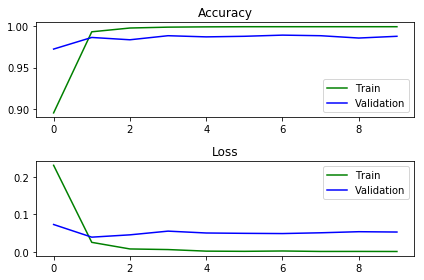

In [15]:
# plot loss and accuracy
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="Train")
plt.plot(history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="Train")
plt.plot(history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [24]:
# evaluate
score, acc = model.evaluate(Xtest, ytest, batch_size=BATCH_SIZE)
print("Test score: %.3f, accuracy: %.3f" % (score, acc))

for i in range(5):
    idx = np.random.randint(len(Xtest))
    xtest = Xtest[idx].reshape(1,40)
    ylabel = ytest[idx]
    ypred = model.predict(xtest)[0][0]
    sent = " ".join([index2word[x] for x in xtest[0].tolist() if x != 0])
    print("%.0f\t%d\t%s" % (ypred, ylabel, sent))

1418/1418 [==============================] - 0s 231us/step
Test score: 0.053, accuracy: 0.988
0	0	always knows what i want , not guy crazy , hates harry potter..
0	0	my dad 's being stupid about brokeback mountain ...
1	1	the da vinci code is awesome..
1	1	i love kirsten / leah / kate escapades and mission impossible tom as well ...
0	0	friday hung out with kelsie and we went and saw the da vinci code sucked ! ! ! ! !


In [21]:
Xtest[0].shape

(40,)

In [22]:
# Numpy의 배열 곱 연산때문에 어쩔 수 없는 것
Xtest[0].reshape(1,40).shape

(1, 40)